In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata

Epoch 0, Loss: 0.008113
Epoch 100, Loss: 0.005476
Epoch 200, Loss: 0.005342
Epoch 300, Loss: 0.004491
Epoch 400, Loss: 0.003342
Epoch 500, Loss: 0.003220
Epoch 600, Loss: 0.002783
Epoch 700, Loss: 0.002569
Epoch 800, Loss: 0.002433
Epoch 900, Loss: 0.002768
Epoch 1000, Loss: 0.002742
Epoch 1100, Loss: 0.002224
Epoch 1200, Loss: 0.002398
Epoch 1300, Loss: 0.002109
Epoch 1400, Loss: 0.002069
Epoch 1500, Loss: 0.002035
Epoch 1600, Loss: 0.002037
Epoch 1700, Loss: 0.002176
Epoch 1800, Loss: 0.001967
Epoch 1900, Loss: 0.001949
Epoch 2000, Loss: 0.001928
Epoch 2100, Loss: 0.002650
Epoch 2200, Loss: 0.001886
Epoch 2300, Loss: 0.001866
Epoch 2400, Loss: 0.001838
Epoch 2500, Loss: 0.001818
Epoch 2600, Loss: 0.001788
Epoch 2700, Loss: 0.001764
Epoch 2800, Loss: 0.002382
Epoch 2900, Loss: 0.001711
Epoch 3000, Loss: 0.001735
Epoch 3100, Loss: 0.001662
Epoch 3200, Loss: 0.001622
Epoch 3300, Loss: 0.001594
Epoch 3400, Loss: 0.001557
Epoch 3500, Loss: 0.001530
Epoch 3600, Loss: 0.001843
Epoch 3700, L

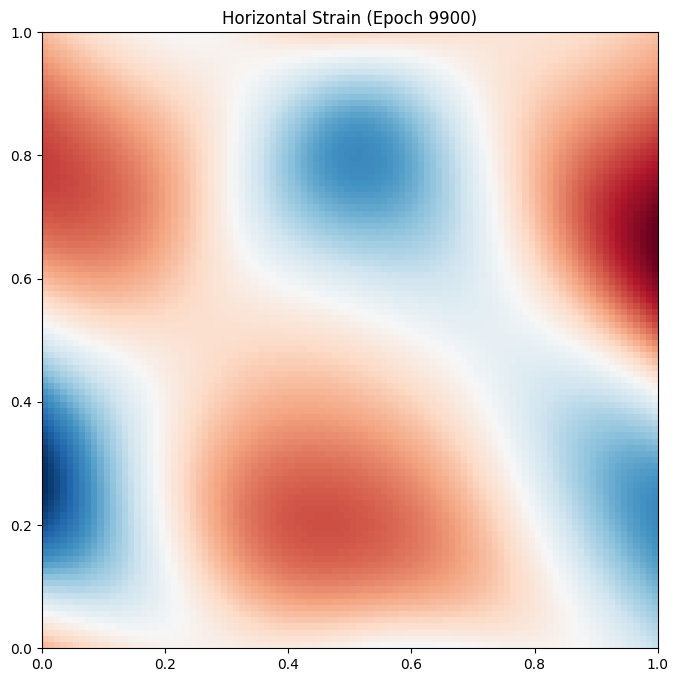

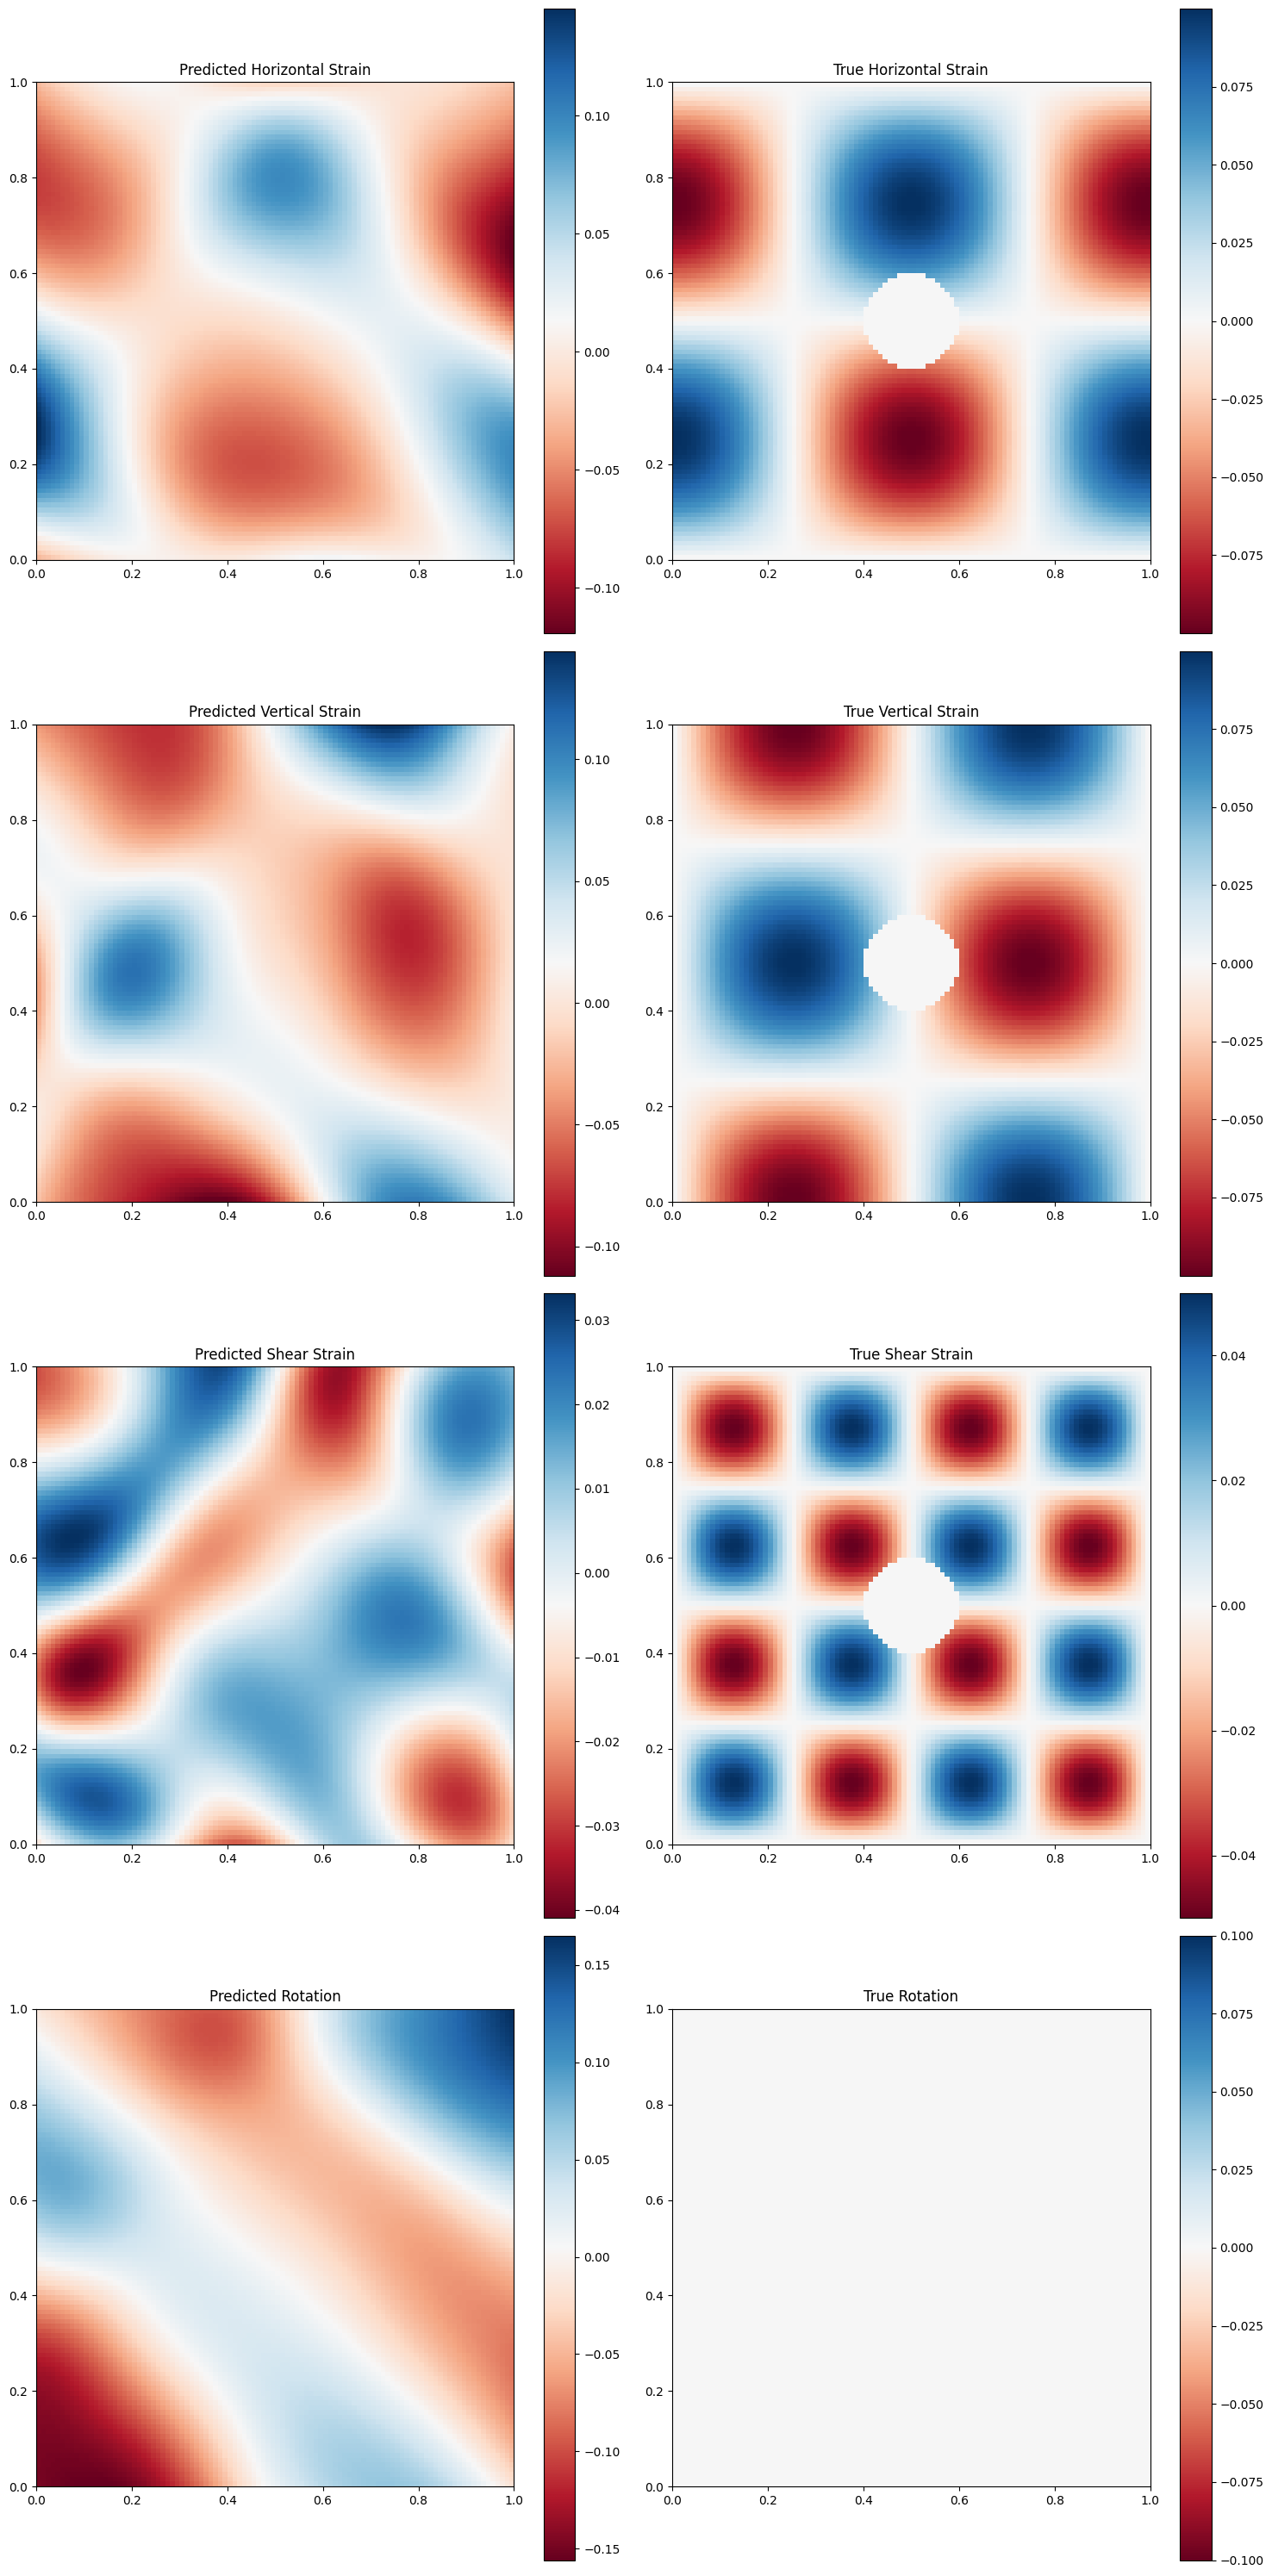

Metrics for exx:
MSE: 0.000240
MAE: 0.012200
RMSE: 0.015484
Max Error: 0.056740
R-squared: 0.903054

Metrics for ezz:
MSE: 0.000263
MAE: 0.012830
RMSE: 0.016215
Max Error: 0.069914
R-squared: 0.893678

Metrics for exz:
MSE: 0.000429
MAE: 0.016433
RMSE: 0.020719
Max Error: 0.063206
R-squared: 0.293409


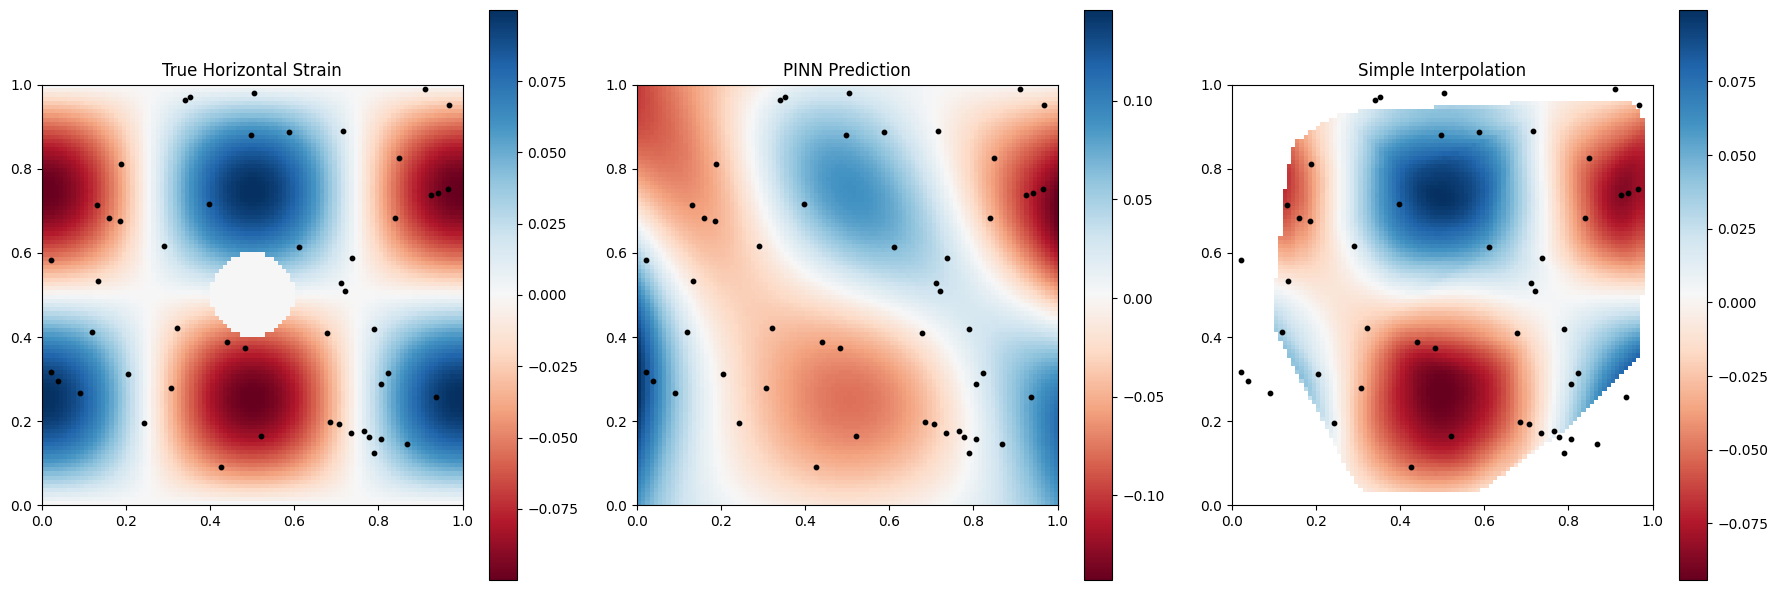

Metrics for PINN:
MSE: 0.000519
MAE: 0.017269
RMSE: 0.022783
Max Error: 0.101088
R-squared: 0.790115

Metrics for Simple Interpolation:
MSE: nan
MAE: nan
RMSE: nan
Max Error: nan
R-squared: nan


In [3]:
class StrainPINN(nn.Module):
    def __init__(self):
        super(StrainPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.net(x)

def strain_components(model, x, z):
    inputs = torch.stack([x, z], dim=1)
    inputs.requires_grad_(True)
    u = model(inputs)
    ux, uz = u[:, 0], u[:, 1]

    exx = torch.autograd.grad(ux.sum(), inputs, create_graph=True)[0][:, 0]
    ezz = torch.autograd.grad(uz.sum(), inputs, create_graph=True)[0][:, 1]
    exz = 0.5 * (torch.autograd.grad(uz.sum(), inputs, create_graph=True)[0][:, 0] +
                 torch.autograd.grad(ux.sum(), inputs, create_graph=True)[0][:, 1])
    rxz = 0.5 * (torch.autograd.grad(uz.sum(), inputs, create_graph=True)[0][:, 0] -
                 torch.autograd.grad(ux.sum(), inputs, create_graph=True)[0][:, 1])

    return exx, ezz, exz, rxz

def pinn_loss(model, x, z, exx_true, ezz_true, exz_true):
    exx_pred, ezz_pred, exz_pred, _ = strain_components(model, x, z)
    
    mse_loss = torch.mean(torch.square(exx_pred - exx_true) +
                          torch.square(ezz_pred - ezz_true) +
                          torch.square(exz_pred - exz_true))
    
    # Add void constraint
    void_mask = ((x - 0.5)**2 + (z - 0.5)**2 <= 0.1**2).float()
    void_loss = torch.mean(torch.square(exx_pred * void_mask) +
                           torch.square(ezz_pred * void_mask) +
                           torch.square(exz_pred * void_mask))
    
    return mse_loss + 10 * void_loss

def generate_data(n_samples=1000):
    x = torch.rand(n_samples)
    z = torch.rand(n_samples)
    
    # Create void
    void_mask = ((x - 0.5)**2 + (z - 0.5)**2 > 0.01**2).float()
    
    # Example strain field with void
    exx = 0.1 * torch.sin(2 * np.pi * x) * torch.cos(2 * np.pi * z) * void_mask
    ezz = -0.1 * torch.cos(2 * np.pi * x) * torch.sin(2 * np.pi * z) * void_mask
    exz = 0.05 * torch.sin(4 * np.pi * x) * torch.sin(4 * np.pi * z) * void_mask
    
    return x, z, exx, ezz, exz

def generate_ground_truth(x, z):
    void_mask = ((x - 0.5)**2 + (z - 0.5)**2 > 0.1**2).float()
    exx = 0.1 * torch.sin(2 * np.pi * x) * torch.cos(2 * np.pi * z) * void_mask
    ezz = -0.1 * torch.cos(2 * np.pi * x) * torch.sin(2 * np.pi * z) * void_mask
    exz = 0.05 * torch.sin(4 * np.pi * x) * torch.sin(4 * np.pi * z) * void_mask
    rxz = torch.zeros_like(exz)  # Assuming zero rotation for ground truth
    return exx, ezz, exz, rxz

def calculate_metrics(pred, true):
    mse = torch.mean((pred - true)**2).item()
    mae = torch.mean(torch.abs(pred - true)).item()
    rmse = np.sqrt(mse)  # Use numpy's sqrt for float values
    max_error = torch.max(torch.abs(pred - true)).item()
    r2 = 1 - torch.sum((true - pred)**2) / torch.sum((true - true.mean())**2)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Max Error': max_error,
        'R-squared': r2.item()
    }

def train_pinn(n_epochs=10000, save_interval=100):
    x, z, exx, ezz, exz = generate_data()

    model = StrainPINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    saved_models = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = pinn_loss(model, x, z, exx, ezz, exz)
        loss.backward()
        optimizer.step()
        
        if epoch % save_interval == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            saved_models.append(model.state_dict())

    return model, saved_models

def visualize_results(model):
    x = torch.linspace(0, 1, 100, requires_grad=True)
    z = torch.linspace(0, 1, 100, requires_grad=True)
    X, Z = torch.meshgrid(x, z, indexing='ij')
    x_flat = X.flatten()
    z_flat = Z.flatten()

    # Predict using the trained model
    exx_pred, ezz_pred, exz_pred, rxz_pred = strain_components(model, x_flat, z_flat)
    
    # Generate ground truth
    exx_true, ezz_true, exz_true, rxz_true = generate_ground_truth(x_flat, z_flat)

    # Prepare data for plotting
    data_pred = [exx_pred, ezz_pred, exz_pred, rxz_pred]
    data_true = [exx_true, ezz_true, exz_true, rxz_true]
    titles = ['Horizontal Strain', 'Vertical Strain', 'Shear Strain', 'Rotation']

    fig, axs = plt.subplots(4, 2, figsize=(15, 30))
    for i, (title, pred, true) in enumerate(zip(titles, data_pred, data_true)):
        # Plot predicted
        im_pred = axs[i, 0].imshow(pred.detach().numpy().reshape(100, 100), 
                                   cmap='RdBu', origin='lower', extent=[0, 1, 0, 1])
        axs[i, 0].set_title(f'Predicted {title}')
        plt.colorbar(im_pred, ax=axs[i, 0])
        
        # Plot ground truth
        im_true = axs[i, 1].imshow(true.detach().numpy().reshape(100, 100), 
                                   cmap='RdBu', origin='lower', extent=[0, 1, 0, 1])
        axs[i, 1].set_title(f'True {title}')
        plt.colorbar(im_true, ax=axs[i, 1])

    plt.tight_layout()
    plt.show()

    # Calculate and print metrics
    metrics_exx = calculate_metrics(exx_pred, exx_true)
    metrics_ezz = calculate_metrics(ezz_pred, ezz_true)
    metrics_exz = calculate_metrics(exz_pred, exz_true)

    print("Metrics for exx:")
    for metric, value in metrics_exx.items():
        print(f"{metric}: {value:.6f}")
    
    print("\nMetrics for ezz:")
    for metric, value in metrics_ezz.items():
        print(f"{metric}: {value:.6f}")
    
    print("\nMetrics for exz:")
    for metric, value in metrics_exz.items():
        print(f"{metric}: {value:.6f}")

def create_animation(saved_models):
    x = torch.linspace(0, 1, 100)
    z = torch.linspace(0, 1, 100)
    X, Z = torch.meshgrid(x, z, indexing='ij')
    x_flat = X.flatten()
    z_flat = Z.flatten()

    fig, ax = plt.subplots(figsize=(8, 8))
    
    model = StrainPINN()

    def animate(i):
        model.load_state_dict(saved_models[i])
        exx_pred, _, _, _ = strain_components(model, x_flat, z_flat)
        ax.clear()
        im = ax.imshow(exx_pred.detach().reshape(100, 100), cmap='RdBu', origin='lower', extent=[0, 1, 0, 1], animated=True)
        ax.set_title(f'Horizontal Strain (Epoch {i*100})')
        return [im]

    anim = FuncAnimation(fig, animate, frames=len(saved_models), interval=200, blit=True)
    anim.save('strain_evolution_complex.gif', writer='pillow')

def demonstrate_sparse_data_advantage(n_sparse_points=50):
    # Generate sparse data
    x_sparse = torch.rand(n_sparse_points)
    z_sparse = torch.rand(n_sparse_points)
    exx_sparse, ezz_sparse, exz_sparse, _ = generate_ground_truth(x_sparse, z_sparse)

    # Train PINN with sparse data
    model = StrainPINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(5000):
        optimizer.zero_grad()
        loss = pinn_loss(model, x_sparse, z_sparse, exx_sparse, ezz_sparse, exz_sparse)
        loss.backward()
        optimizer.step()

    # Generate full grid for comparison
    x = torch.linspace(0, 1, 100)
    z = torch.linspace(0, 1, 100)
    X, Z = torch.meshgrid(x, z, indexing='ij')
    x_flat = X.flatten()
    z_flat = Z.flatten()

    # PINN prediction
    exx_pinn, _, _, _ = strain_components(model, x_flat, z_flat)
    exx_pinn = exx_pinn.detach().numpy().reshape(100, 100)

    # Simple interpolation
    exx_interp = griddata((x_sparse, z_sparse), exx_sparse, (X, Z), method='cubic')

    # True values
    exx_true, _, _, _ = generate_ground_truth(x_flat, z_flat)
    exx_true = exx_true.detach().numpy().reshape(100, 100)

    # Visualize results
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    im0 = axs[0].imshow(exx_true, cmap='RdBu', origin='lower', extent=[0, 1, 0, 1])
    axs[0].set_title('True Horizontal Strain')
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(exx_pinn, cmap='RdBu', origin='lower', extent=[0, 1, 0, 1])
    axs[1].set_title('PINN Prediction')
    plt.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(exx_interp, cmap='RdBu', origin='lower', extent=[0, 1, 0, 1])
    axs[2].set_title('Simple Interpolation')
    plt.colorbar(im2, ax=axs[2])

    for ax in axs:
        ax.scatter(x_sparse, z_sparse, c='k', s=10)

    plt.tight_layout()
    plt.show()

    # Calculate and print metrics
    metrics_pinn = calculate_metrics(torch.tensor(exx_pinn.flatten()), torch.tensor(exx_true.flatten()))
    metrics_interp = calculate_metrics(torch.tensor(exx_interp.flatten()), torch.tensor(exx_true.flatten()))

    print("Metrics for PINN:")
    for metric, value in metrics_pinn.items():
        print(f"{metric}: {value:.6f}")
    
    print("\nMetrics for Simple Interpolation:")
    for metric, value in metrics_interp.items():
        print(f"{metric}: {value:.6f}")

In [ ]:
# Run the training
trained_model, saved_models = train_pinn()

# Create animation
create_animation(saved_models)

# Visualize the results
visualize_results(trained_model)

# Demonstrate advantage with sparse data
demonstrate_sparse_data_advantage()